# Final Project Pagerank

Processing the data

In [5]:
from sentence_transformers import SentenceTransformer
import warnings
warnings.filterwarnings("ignore")
import spacy
import pandas as pd
from collections import Counter, defaultdict
import numpy as np
import os
import re
from io import StringIO
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import nltk
import numpy as np
import matplotlib.pyplot as plt
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale 
from spacy.lang.en.stop_words import STOP_WORDS
from functools import lru_cache
import timeit
import pickle


def eda(sentences):
    processed_sentences = []

    for s in sentences:
        # Remove all the special characters
        processed_sentence = re.sub(r'\W', ' ', str(s))

        # remove all single characters
        processed_sentence= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_sentence)

        # Remove single characters from the start
        processed_sentence = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_sentence) 

        # Substituting multiple spaces with single space
        processed_sentence = re.sub(r'\s+', ' ', processed_sentence, flags=re.I)

        # Removing prefixed 'b'
        processed_sentence = re.sub(r'^b\s+', '', processed_sentence)

        # Converting to Lowercase
        processed_sentence = processed_sentence.lower()

        processed_sentences.append(processed_sentence)
        
    return processed_sentences

@lru_cache(maxsize=128)
def getData(method):
  wd = os.getcwd()
  transcripts = []
  dino_df = pd.DataFrame()
  km_df = pd.DataFrame()
  dino_ts = {}
  
  cachedStopWords = list(set(stopwords.words("english") + list(STOP_WORDS) + list(STOPWORDS) + ['so data','lot','someone','need','find','unknown','speaker','so data','okay so','so','unknown speaker','actually','many','make','people','ten','go','see','want','yeah','zero','two','three','four','five','six','eight','nine','going','okay','one','say','look','hundred','minus','little','let','um','uh','unknown','right','know','user','avatar','dino','konstantopoulos','yutong','gao']))
  #'sure','little','speaker','things','lot','think','work','way','new','one','number','different','yeah','probability','use','zero','actually' ,'function','say','look','want' ,'okay' ,'let', 'going', 'machine', 'learning', 'data',
  pattern = re.compile(r'\b(' + r'|'.join(cachedStopWords) + r')\b\s*')
  pattern2 = r'[0-9]'
  custom = ['so data','lot','someone','need','find','unknown','speaker','so data','okay so','so','unknown speaker','actually','many','make','people','ten','go','see','want','yeah','zero','two','three','four','five','six','eight','nine','going','okay','one','say','look','hundred','minus','little','let','um','uh','unknown','right','know','user','avatar','dino','konstantopoulos','yutong','gao']
  pattern3 = re.compile(r'\b(' + r'|'.join(custom) + r')\b\s*')
  
  all_words = ""
  
  for files in os.listdir(wd+"/Dino-Until-Nov-21"):
    str1 = open(wd+"/Dino-Until-Nov-21/"+files, 'r',encoding="utf-8").read()   
    StringData = StringIO(str1)
    df = pd.read_csv(StringData, sep ="\\n",header=None)
    df['Relevant_Date'] = files.split(".")[0]
    km_df = pd.concat([km_df,df])
    dino_df = pd.concat([dino_df,df])
    str1 = eda([str1])[0]
    str1 = re.sub(pattern,'',str1)
    str1 = re.sub(pattern2,'',str1)  
    str1 = re.sub(pattern3,'',str1)  
    dino_ts[files] = str1
    transcripts.append(str1)
    
  dino = " ".join(map(str, transcripts))  
  
  transcripts = [eda([x])[0] for x in transcripts]
  
  dino_df.iloc[:,0] = dino_df.iloc[:,0].apply(lambda x :  re.sub(pattern, '', x))
  dino_df.iloc[:,0] = dino_df.iloc[:,0].apply(lambda x :  re.sub(pattern2, '', x))
  dino_df.iloc[:,0] = dino_df.iloc[:,0].apply(lambda x :  re.sub(pattern3, '', x))
  dino_df.iloc[:,0] = dino_df.iloc[:,0].apply(lambda x :  re.sub(r'[^\w\s]','',x))
  dino_df.iloc[:,0] = dino_df.iloc[:,0].apply(lambda x : eda([x])[0])
  dino_df = dino_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
  dino_df = dino_df[((dino_df.iloc[:,0]!=''))]
  dino_df = dino_df[(dino_df.iloc[:,0].str.split().str.len() > 2)]
  
  
  km_df.iloc[:,0] = km_df.iloc[:,0].apply(lambda x :  re.sub(pattern3, '', x))
  km_df = km_df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
  km_df = km_df[((km_df.iloc[:,0]!=''))]
  km_df = km_df[(km_df.iloc[:,0].str.split().str.len() > 2)]
  
  corpus = km_df.iloc[:,0].to_list()
  corpus = list(map(''.join, zip(*([iter(corpus)]*3))))  

  #Important Paramter #1
  corpus = list(map(''.join, zip(*([iter(corpus)]*3))))  

  customn = ['so','then','thing','okay','right','um','al','rry','mm']
  all_words_list = all_words.split()
  for word in custom:
      while word in all_words_list:
          dino_df.iloc[:,0] = dino_df.iloc[:,0].str.replace(word,"")
          km_df.iloc[:,0] = km_df.iloc[:,0].str.replace(word,"")
          all_words_list.remove(word)

  if method == "Pagerank":
    return km_df
  elif method == 'EDA':
    return [dino_df,dino_ts,transcripts]
  elif method == 'AllWords':
    return all_words_list

# EDA for Textrank

We need to use Bert embeddings to make a sparse matrix from corpus

In [6]:
tr_df = getData('EDA')

In [5]:
tr_df

[                                                     0 Relevant_Date
 10                     wait requirements three minutes        Nov-10
 18   so thinking postpone correction home midterm c...        Nov-10
 20                        review class what guys think        Nov-10
 21            what online think send think chat window        Nov-10
 24   either the online midterm fresh mind so they c...        Nov-10
 ..                                                 ...           ...
 622  okay home time please installs tell slides bri...         Sep-8
 623  working teams hard work so ready semester hard...         Sep-8
 625  so lectures recorded so watch for reason miss ...         Sep-8
 626  thank tas not tas itry tas class rotate able s...         Sep-8
 628            so learn use you use fighter but things         Sep-8
 
 [8346 rows x 2 columns],
 {'Nov-10.txt': 'question       wait requirements minutes       thinking postpone correction home midterm class monday review class 

In [7]:
Pg_df = getData('Pagerank')  
corpus = Pg_df.iloc[:,0].to_list()
bmodel = SentenceTransformer('all-MiniLM-L6-v2') #384 dims
save_model = False

In [8]:
Pg_df

,0,Relevant_Date
0,The only question.,Nov-10
10,Wait another requirements. Three minutes.,Nov-10
18,". So , i'm thinking we postpone the correction...",Nov-10
19,because there's nobody here,Nov-10
20,"and , and we just do a review of what we did l...",Nov-10
...,...,...
845,"you? No, it's not important. This is more impo...",Sept-29
846,"Yeah, you have homework. That's due on Saturday.",Sept-29
850,We don't have shared.,Sept-29
854,"Okay, now, good luck, Good luck. Good luck. Ok...",Sept-29


In [9]:
wd = os.getcwd()
wd

'C:\\Users\\HP\\Data science INFO6150\\Final Project_Data_Science'

# Tokenising the Transcript using BERT embeddings

In [11]:
Pg_df = getData('Pagerank')  
corpus = Pg_df.iloc[:,0].to_list()
bmodel = SentenceTransformer('all-MiniLM-L6-v2') #384 dims
save_model = True
if save_model:


  #Important Paramter#1

  corpus = list(map(''.join, zip(*([iter(corpus)]*3))))      
  bert_embeddings = bmodel.encode(corpus)
  bert_embeddings.shape
  with open(wd+"\\"+'doc_embedding.pickle', 'wb') as pkl:
      pickle.dump(bert_embeddings, pkl)

with open(wd+"\\"+'doc_embedding.pickle', 'rb') as pkl:
    bert_embeddings = pickle.load(pkl)

bert_embeddings_std = scale(bert_embeddings)  
bert_embeddings_red = PCA(n_components=3).fit_transform(bert_embeddings_std)

h = 0.02 #step size of the mesh 
#Minimum and maximum x-coordinates
xmin, xmax = bert_embeddings_red[:, 0].min() - 1, bert_embeddings_red[:, 0].max() + 1
#Minimum and maximum y-coordinates
ymin, ymax = bert_embeddings_red[:, 1].min() - 1, bert_embeddings_red[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(xmin, xmax, h), np.arange(ymin, ymax, h))

In [12]:
bert_embeddings.shape

(3379, 384)

# Building a similarity Matrix using cosine similarity

In [28]:
#Tokeninsing the transcripts
for i, (sentence, embedding) in enumerate(zip(corpus, bert_embeddings)):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")
    if i == 3: break

Sentence: The only question.Wait another requirements. Three minutes.. So , i'm thinking we postpone the correction of the take home and the midterm in class to Monday,
Embedding: [-3.18036531e-03  2.09598877e-02  5.11746183e-02 -4.22982834e-02
  1.42275961e-02  4.12088782e-02 -1.13496535e-01 -2.93880198e-02
 -6.74638152e-02  2.87976544e-02 -1.66551105e-03  3.02034654e-02
 -3.74928750e-02 -2.05023047e-02  2.14531347e-02 -1.40876614e-03
 -2.38988101e-02 -1.36479046e-02 -6.19586110e-02  1.18717633e-01
  4.17304859e-02 -3.50131467e-02  1.85046147e-03  4.93377224e-02
  3.18483077e-02  2.60256454e-02  3.74393836e-02  4.21172939e-02
 -1.44744748e-02 -7.18176067e-02 -7.74016902e-02  1.68589763e-02
  6.14920445e-02  2.91945264e-02  1.64610203e-02  2.82274000e-02
  7.44910985e-02 -7.57901883e-03  7.69602433e-02  1.66429747e-02
  1.89550240e-02 -4.23910059e-02 -3.04426625e-03  9.23681930e-02
 -1.90915354e-02  2.51028538e-02 -5.66946948e-03 -3.64874192e-02
  3.50052677e-02  2.61130985e-02 -4.3089

In [14]:
import numpy as np
a = bert_embeddings[0]
b = bert_embeddings[1]
cos_sim = (a @ b.T) / (np.linalg.norm(a)*np.linalg.norm(b))
cos_sim

0.3050172

In [15]:
from tqdm import tqdm
#M = np.zeros((1933, 1933))
M = np.eye(bert_embeddings.shape[0])

for i,a in tqdm(enumerate(bert_embeddings)):
    for j,b in enumerate(bert_embeddings):
        if i != j:
            M[i,j] = (a @ b.T) / (np.linalg.norm(a)*np.linalg.norm(b))

3379it [03:23, 16.58it/s]


Creating a similarity graph using NetworkX

In [17]:
import networkx

similarity_graph = networkx.from_numpy_array(M)
similarity_graph

In [19]:
pos=networkx.circular_layout(similarity_graph)

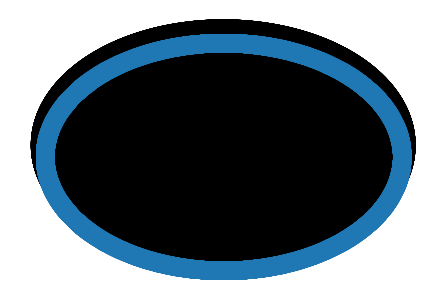

In [21]:
networkx.draw(similarity_graph, pos=pos)

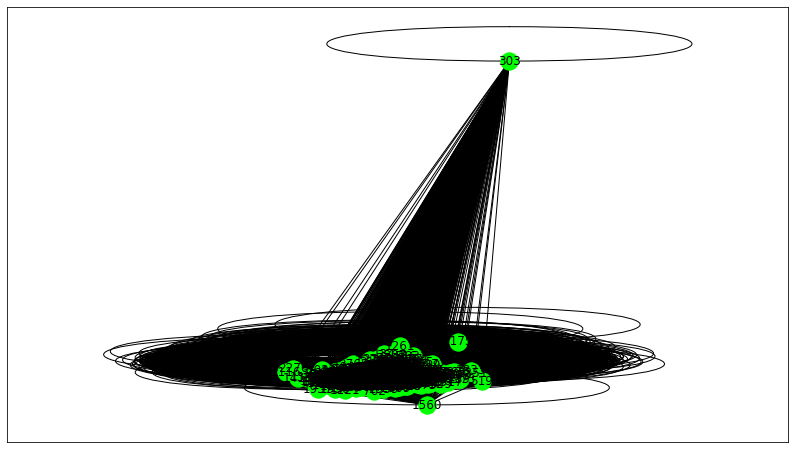

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(14, 8))
networkx.draw_networkx(similarity_graph, node_color='lime', with_labels=True)
#with_labels=True

In [22]:
scores = networkx.pagerank(similarity_graph)
nx_ranked_sentences = sorted(((score, index) for index, score 
                                            in scores.items()), 
                          reverse=True)
nx_ranked_sentences[:20]

[(0.0004943475582944004, 2185),
 (0.000494008343135378, 1471),
 (0.0004938911120561097, 848),
 (0.0004919296010176254, 1031),
 (0.0004912897683235122, 2215),
 (0.00048774184891315215, 2067),
 (0.0004852577131736249, 1873),
 (0.0004823765514344341, 2119),
 (0.00048052331550182254, 1126),
 (0.0004790548821575623, 1776),
 (0.0004751665960922352, 426),
 (0.00047237289662764684, 2562),
 (0.00047089394768510347, 926),
 (0.00046861294652331874, 2305),
 (0.00046798846278272395, 1734),
 (0.0004661891350812778, 624),
 (0.0004622970329571994, 2134),
 (0.0004620885080789367, 1808),
 (0.0004620393962678902, 19),
 (0.0004614919024514661, 1188)]

In [1]:
nx_ranked_sentences[303]

NameError: name 'nx_ranked_sentences' is not defined

In [23]:
len(nx_ranked_sentences)

3379

In [29]:
#Prining the top ranked 40 sentences from all the classes
for i in range(40):
    print(corpus[nx_ranked_sentences[i][1]])
    print('----------')

a bunch of numbers, but it's a function. Nowi'm telling you it's a function. I it to be fifty dimensional.So if I paste this, and I hope you're all doing the same thing, i'm doing, and then I ask for X. Bless you! You will that X. Now has
----------
? You can that the the the valuethe the use around , ? So we generate the data we around . So that's that's the value we're looking for. So 's suppose we don't that value.So 's 's start with a guess around , and 's where it takes us.
----------
and you do that by looking at the histogram. And then you , Okay, what function do I that looks like it in class we learned,you , maybe maybe half a dozen functions that we can use single hunt function far that we can use to approximate the data. And then you , Okay, Um, these functions have a few parameters. Let me out the parameters,and it's a it's it's !
----------
And we to aBefore that you at the histogram, and then you what?Exactly that's the d you at the histogram, you ? Does this like a Gauss